In [23]:
""" 
Fine tune a image captioning or description model on a artwork description data to
obtain a model that is able to analyze an artwork and generate a description of 
the artwork that is hopefully more art-review-like than a generic image captioning 
model would

The pretrained model used here is the Salesforce Blip Captioniong model: 
https://huggingface.co/Salesforce/blip-image-captioning-base

The fine tuning data set is the data from the SemArt Project: 
https://github.com/noagarcia/SemArt
"""

' \nFine tune a image captioning or description model on a artwork description data to\nobtain a model that is able to analyze an artwork and generate a description of \nthe artwork that is hopefully more art-review-like than a generic image captioning \nmodel would\n\nThe pretrained model used here is the Salesforce Blip Captioniong model: \nhttps://huggingface.co/Salesforce/blip-image-captioning-base\n\nThe fine tuning data set is the data from the SemArt Project: \nhttps://github.com/noagarcia/SemArt\n'

In [24]:
import os
import torch
import pandas as pd
import torch.nn as nn
import chardet
from PIL import Image
from torchvision import transforms
from datasets import Dataset, DatasetDict
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import datasets
from datasets import Dataset as HFDataset, DatasetDict, IterableDataset
from transformers import BlipProcessor, BlipForConditionalGeneration, ViTImageProcessor, VisionEncoderDecoderModel, AutoTokenizer, TrainingArguments, Trainer

In [25]:
def list_files_in_directory(dir_path):
    try:
        files = os.listdir(dir_path)
        return [x for x in files if '.jpg' in x]
    except FileNotFoundError:
        return f"Directory not found: {dir_path}"
    except NotADirectoryError:
        return f"Not a directory: {dir_path}"

In [26]:
import pandas as pd
import torch
from torchvision import transforms
from PIL import Image
import os

# Step 1: Load the CSV file as a dictionary mapping image names to descriptions
semart_dir = f"/Users/rckyi/Documents/Datasette/SemArtData/SemArt" 
images_dir = semart_dir 

description_file_train = semart_dir + '/semart_train.csv'
description_file_test = semart_dir + '/semart_test.csv'

with open(description_file_train, 'rb') as file:
    print(f'file path {description_file_train}')
    result = chardet.detect(file.read())
    encoding = result['encoding']
    print(f'encoding {encoding}')
    df_train = pd.read_csv(description_file_train, encoding=encoding, sep='\t')
    print(type(df_train['IMAGE_FILE'][0]))
    df_test = pd.read_csv(description_file_test, encoding=encoding, sep='\t')


image_to_description_train = dict(zip(df_train["IMAGE_FILE"], df_train["DESCRIPTION"]))
image_to_description_test = dict(zip(df_test["IMAGE_FILE"], df_test["DESCRIPTION"]))
# list(image_to_description.items())[0:5]

# # Define the image directory and transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to a fixed shape
    transforms.ToTensor(),  # Convert image to tensor
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])


file path /Users/rckyi/Documents/Datasette/SemArtData/SemArt/semart_train.csv
encoding utf-8
<class 'str'>


In [27]:
image_files_in_dir = list_files_in_directory(semart_dir+'/Images/')

In [28]:
from datasets import IterableDataset, DatasetDict
from transformers import BlipProcessor, BlipForConditionalGeneration, TrainingArguments, Trainer            

def data_generator_train():
    image_file_list = list(df_train['IMAGE_FILE'])
    for image_name in image_files_in_dir:
        image_path = f"{semart_dir}/Images/{image_name}"

        if image_name in image_file_list: #image_to_description: # and os.path.exists(image_path):
            image = Image.open(image_path).convert("RGB")
            image_tensor = transform(image)
            yield {"image":image_tensor, "text":image_to_description_train[image_name]}
            
def data_generator_test():
    image_file_list = list(df_test['IMAGE_FILE'])
    for image_name in image_files_in_dir:
        image_path = f"{semart_dir}/Images/{image_name}"

        if image_name in image_file_list: #image_to_description: # and os.path.exists(image_path):
            image = Image.open(image_path).convert("RGB")
            image_tensor = transform(image)
            yield {"image":image_tensor, "text":image_to_description_test[image_name]}

In [29]:
hf_dataset = DatasetDict({"train": datasets.Dataset.from_generator(data_generator_train)
                         , "test": datasets.Dataset.from_generator(data_generator_test)})

Loading dataset shards:   0%|          | 0/20 [00:00<?, ?it/s]

In [30]:
def transforms(example_batch):
    images = np.asarray([x for x in example_batch["image"]])
    captions = [x for x in example_batch["text"]]
    inputs = processor(images=images, text=captions, 
                       padding="max_length",   # ✅ Pads or truncates to max_length
                        truncation=True,        # ✅ Prevents sequences longer than max_length
                        max_length=512  )
    inputs.update({"labels": inputs["input_ids"]})
    return inputs

hf_dataset.set_transform(transforms)

In [31]:
# Define Training Arguments
training_args = TrainingArguments(
    output_dir="./blip-semart-finetuned",
    per_device_train_batch_size=8,
    num_train_epochs=5,
    save_steps=500,
#     evaluation_strategy=None,
    evaluation_strategy="steps",
    save_total_limit=2,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    push_to_hub=False,  # Set to True if uploading to Hugging Face Hub
    logging_steps=10,
    fp16=torch.cuda.is_available(),
    remove_unused_columns=False,
    max_steps=300,
    no_cuda=True,
)

/Users/rckyi/miniforge3/envs/torch-gpu/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/Users/rckyi/miniforge3/envs/torch-gpu/lib/python3.8/site-packages/transformers/training_args.py:1583: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


In [32]:
# Load Pretrained BLIP Model & Processor
model_name = "Salesforce/blip-image-captioning-base"
processor = BlipProcessor.from_pretrained(model_name)
model = BlipForConditionalGeneration.from_pretrained(model_name)

In [33]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [34]:
# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset = hf_dataset["train"],
    eval_dataset = hf_dataset["test"],
    tokenizer=processor,
#     data_collator=collate_fn,  # Use custom collate function to prepare batches
)

<ipython-input-34-a18405505b84>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
max_steps is given, it will override any value given in num_train_epochs


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [35]:
# Start Fine-Tuning
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: shaddie77 (shaddie77-personal) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Step,Training Loss,Validation Loss
10,9.369800,7.868719
20,7.296600,6.785567
30,6.383000,5.883533
40,5.517100,5.028250
50,4.656100,4.190298
60,3.923400,3.416447
70,2.987600,2.727108
80,2.353900,2.169645
90,2.059800,1.779664
100,1.559600,1.551912


TrainOutput(global_step=300, training_loss=2.3670225048065188, metrics={'train_runtime': 72807.6436, 'train_samples_per_second': 0.033, 'train_steps_per_second': 0.004, 'total_flos': 1.4242167653400576e+18, 'train_loss': 2.3670225048065188, 'epoch': 0.12468827930174564})

In [36]:
# Save the fine-tuned model
trainer.save_model("./blip-semart-finetuned_model")
processor.save_pretrained("./blip-semart-finetuned_model")

print("Fine-tuning complete! Model saved at './blip-semart-finetuned_model'")

Fine-tuning complete! Model saved at './blip-semart-finetuned_model'


In [37]:
from huggingface_hub import notebook_login
notebook_login()

In [38]:
model.push_to_hub("shaddie/blip-semart-finetuned_model",
                  use_auth_token=True,
                  commit_message="fine-tuning-exercises",
                  private=True)

/Users/rckyi/miniforge3/envs/torch-gpu/lib/python3.8/site-packages/transformers/utils/hub.py:894: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/shaddie/blip-semart-finetuned_model/commit/b5bfa01cab56602b9b61d3c041f4a609047cbf3a', commit_message='fine-tuning-exercises', commit_description='', oid='b5bfa01cab56602b9b61d3c041f4a609047cbf3a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/shaddie/blip-semart-finetuned_model', endpoint='https://huggingface.co', repo_type='model', repo_id='shaddie/blip-semart-finetuned_model'), pr_revision=None, pr_num=None)

In [39]:
image_files_in_dir

['39799-21gritti.jpg',
 '10637-peasants.jpg',
 '44435-tributem.jpg',
 '33615-04sp1629.jpg',
 '15432-pieta.jpg',
 '18358-1509grec.jpg',
 '08684-09deadph.jpg',
 '42808-2baptism.jpg',
 '36530-port_wom.jpg',
 '18298-1012grec.jpg',
 '26541-04_0bay4.jpg',
 '03862-138sacr.jpg',
 '33578-123portr.jpg',
 '42242-0310vela.jpg',
 '20975-still_li.jpg',
 '40823-youngwo1.jpg',
 '24963-cassone4.jpg',
 '17796-701goya.jpg',
 '35499-29mythol.jpg',
 '40178-tonneman.jpg',
 '05374-flower_.jpg',
 '26742-04_1sp3f.jpg',
 '39742-08pardo.jpg',
 '42336-pastoral.jpg',
 '02998-portrait.jpg',
 '14508-flowers.jpg',
 '23852-3manet11.jpg',
 '17288-selfpo15.jpg',
 '20938-mirror.jpg',
 '39427-1antico2.jpg',
 '23573-peelin.jpg',
 '07773-50dream.jpg',
 '39151-15zianig.jpg',
 '31178-9exal01.jpg',
 '08990-05ursula.jpg',
 '19280-port_wom.jpg',
 '24212-madonna2.jpg',
 '32977-09chigi2.jpg',
 '25205-resurrec.jpg',
 '23861-3manet20.jpg',
 '03530-olindo.jpg',
 '07603-60alof.jpg',
 '31198-93restau1.jpg',
 '14964-tahiti10.jpg',
 '116

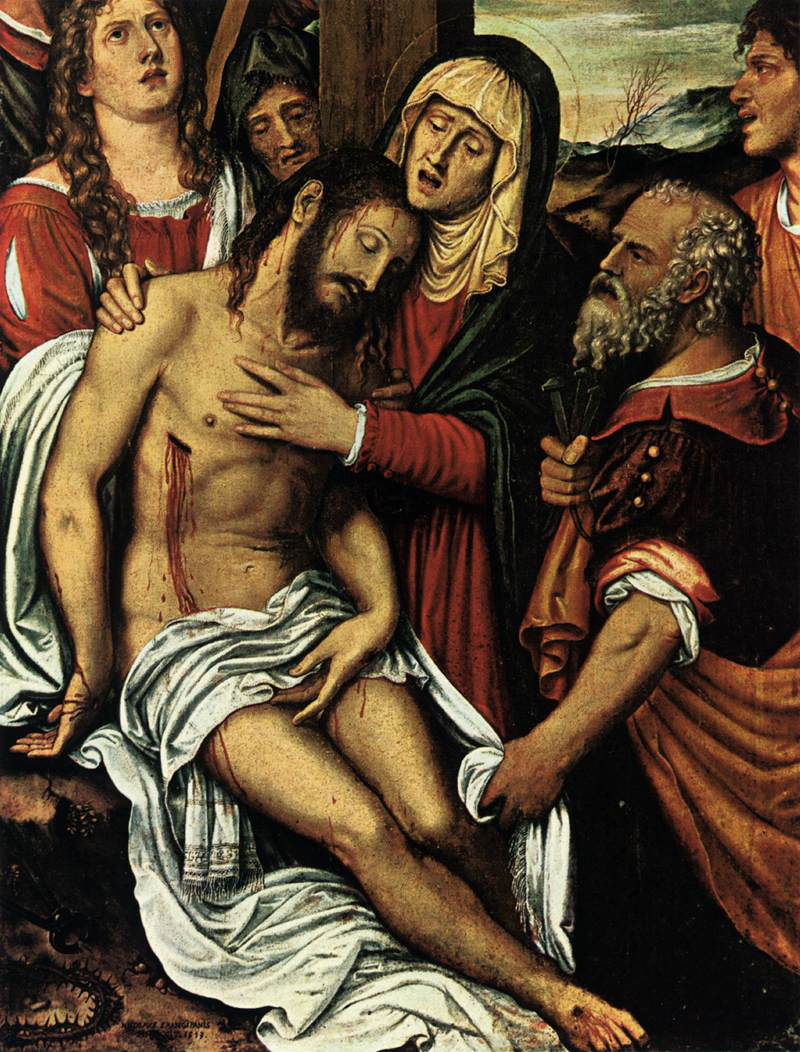

In [502]:
from PIL import Image
import requests

im_path = semart_dir+'/Images/'+ '14401-pieta.jpg'
image = Image.open(im_path)
image

In [503]:
from accelerate.test_utils.testing import get_backend

device, _, _ = get_backend()
inputs = processor(images=image, return_tensors="pt").to(torch.float).to(device)
pixel_values = inputs.pixel_values.to(torch.float)
model = model.to(device)
pixel_values

tensor([[[[ 0.5873,  0.5873,  0.7917,  ..., -1.4565, -1.3981, -1.3835],
          [ 0.9376,  0.9376,  1.1274,  ..., -1.5441, -1.5587, -1.4857],
          [ 1.1128,  1.1420,  1.2150,  ..., -1.5149, -1.5879, -1.4857],
          ...,
          [-0.8142, -1.1499, -1.4565,  ..., -1.4127, -1.5149, -1.3981],
          [-0.7120, -0.9018, -1.1353,  ..., -1.6171, -1.5879, -1.5003],
          [-0.9748, -0.9602, -1.0769,  ..., -1.6025, -1.5003, -1.3105]],

         [[-0.3414, -0.3414, -0.1613,  ..., -1.4219, -1.3619, -1.3469],
          [-0.2813, -0.2663, -0.0412,  ..., -1.5120, -1.5270, -1.4519],
          [-0.2963, -0.2513, -0.1313,  ..., -1.4820, -1.5570, -1.4519],
          ...,
          [-0.9417, -1.2418, -1.4820,  ..., -1.4219, -1.5120, -1.3919],
          [-0.8216, -1.0317, -1.2718,  ..., -1.5870, -1.5270, -1.4519],
          [-1.0317, -1.0467, -1.2418,  ..., -1.4970, -1.3769, -1.1818]],

         [[-0.5275, -0.5986, -0.5417,  ..., -1.1958, -1.1389, -1.1247],
          [-0.4990, -0.5559, -

In [504]:
# model.generate(**inputs, num_beams=4, do_sample=True)

generated_ids = model.generate(pixel_values=pixel_values, max_length=150, num_beams=1, do_sample=True)
generated_ids

tensor([[30522,  2023,  5997,  2013,  1996,  3653, 12662,  2050, 11230,  5019,
          2013,  1996,  6896,  1997,  4748, 27296,  2271,  1998,  1996, 16222,
          6305, 27605,  6155,  2029,  3653, 12662,  2050,  2550,  3365,  5019,
          1012,  2035,  5019,  2013,  1996,  3496,  2003,  6052,  1999,  1996,
          3653, 12662,  2050,  1012,  1996,  3496,  2003,  2112,  1997,  1996,
          5402,  1997,  1037,  2186,  1997,  3157,  5019, 10775,  4828,  1005,
          1055, 13675, 14194, 10128,  7646,  3258,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,  1996,  3496,  1999,  1996,  8312,  2003,  5171,
          1997,  7988,  1011,  3412,  7984,  5019,  1999,  6744,  1010,  2029,
          2031,  2042,  6791,   102]], device='mps:0')

In [505]:
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_caption

["this panel from the predella depicts scenes from the passion of adonisus and the accacimides which predella produced numerous scenes. all scenes from the scene is dated in the predella. the scene is part of the cycle of a series of nine scenes depicting christ ' s crucifixion the scene in the presentation is typical of christianity - religious narrative scenes in jerusalem, which have been portrayed"]

In [506]:
# model.generation_config

GenerationConfig {
  "bos_token_id": 30522,
  "eos_token_id": 2,
  "pad_token_id": 0
}

In [507]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load the model and tokenizer
model_name = "Vamsi/T5_Paraphrase_Paws"
# model_refine_name = "ramsrigouthamg/t5_paraphraser"
tokenizer = AutoTokenizer.from_pretrained(model_refine_name)
model_refine = AutoModelForSeq2SeqLM.from_pretrained(model_refine_name)



In [508]:
# Input sentence
sentence = generated_caption

# Prepare input with a paraphrasing prompt
input_text = f"paraphrase: {sentence} </s>"
input_ids = tokenizer.encode(input_text, return_tensors="pt")


In [509]:
# Generate refined sentence
outputs = model_refine.generate(input_ids, max_length=128, num_beams=10, early_stopping=False)
# outputs[0]

tensor([    0,   784,   121,  8048,  2952,    45,     8,   554,    26,  5303,
         9850,     7,  8073,    45,     8,  2987,    13,     3,     9,  2029,
          159,   302,    11,     8,     3,  6004,  4268,    51,  9361,    84,
          554,    26,  5303,  2546,  2724,  8073,     5,    66,  8073,    45,
            8,  3112,    19,     3, 14134,    16,     8,   554,    26,  5303,
            5,     8,  3112,    16,     8,  3831,    19,  4541,    13,     3,
        15294,    23,   152,   485,     3,    18,  4761,  8109,  8073,    16,
          528,  4502,     9,   109,    51,     6,    84,    43,   118,     3,
        27486,   121,   908,     1])

In [510]:
refined_sentence = tokenizer.decode(outputs[0], skip_special_tokens=True)

refined_sentence

'["this panel from the predella depicts scenes from the passion of adonisus and the accacimides which predella produced numerous scenes. all scenes from the scene is dated in the predella. the scene in the presentation is typical of christianity - religious narrative scenes in jerusalem, which have been portrayed"]'